## Cell Fate Decision Generative Model

The form of our data: 

After processing, we obtain number density fractions of difference cell types. These are as follows:

$n_b$=number density of pluripotent cells (both markers) per unit area (# 'both' cells in box)

$n_r$=density of red cells (Oct4) (# 'red' cells in box)

$n_g$=density of green cells (Sox2) (# 'green' cells in box)

Between two time steps, we assert the following: 

$$\Delta n_b= n_{entering, b} - n_{leaving, b} + n_{dividing, b} -n_{b\rightarrow g } - n_{g\rightarrow b}$$

Where $n_{entering, b}$ denotes the number of pluripotent cells entering the ROI, $n_{leaving, b}$ denotes the number exiting the ROI, $n_{dividing,b}$ denotes the number of pluripotent cells in the ROI that divide, $n_{b\rightarrow g } $ the number of cells that differentiate to green, and $n_{g\rightarrow b}$ the number of cells that differentiate to blue. 

$$\Delta n_g= n_{entering, g} - n_{leaving, g} + n_{dividing, g} +n_{b\rightarrow g } $$

Where $n_{entering, g}$ denotes the number of green cells entering the ROI, $n_{leaving, g}$ denotes the number exiting the ROI, and $n_{dividing,g}$ denotes the number of green cells in the ROI that divide.  

$$\Delta n_r= n_{entering, r} - n_{leaving, r} + n_{dividing, r} +n_{b\rightarrow r } $$

With variables defined as above. 

We can then convert these to differential equations (modulo some scaling factor):


$$ \frac{d n_b (t,x)}{dt}  = k_{entry}n_b(t,x_{neighbors})+(k_{division}-k_{departure}) n_b(t,x) - (k_{b\rightarrow g } + k_{b \rightarrow r})n_{b}(t,x) $$

$$ \frac{d n_g (t,x)}{dt} = k_{entry}n_g(t,x_{neighbors})+(k_{division}-k_{departure}) n_g(t,x) + k_{b\rightarrow g } n_{b}(t,x) $$

$$ \frac{d n_r (t,x)}{dt} = k_{entry}n_r(t,x_{neighbors})+(k_{division}-k_{departure}) n_r(t,x) + k_{b\rightarrow r } n_{b}(t,x) $$

Once we include noise, numerically solving this set of differential equations should recapitulate our data. To simplify analysis, we may choose to approximate $x_{neighbors}$ by $x$ because we expect density to vary slowly over the scale of a small number of analysis areas. Additionally, we have assumed above that $k_{division}$ is the same for all three cell types, as well as rates of motion. This should hold because these cell types are very similar, and are not readily distinguishable without these tags. 

The rates $k$ above are the average rates; in practice, the number densities will be non-deterministic due to various sources of error including: 

- errors due to cell counting algorithm (stochasticity from the observation)
    - To process our data set, we use a black-box cell counting software from MIT's Broad Institute. While this software is very good, it is still not perfect (and is also not as good as the naked eye). It will make errors due to issues such as image quality and resolution (blurring cell outlines), a wide spread of cell sizes (this type of segmentation algorithm usually does better when cells are relatively uniform in size), and possible overlap between cells. Because this is a mixture of many types of uncertainties, each of which has an unknown distribution. A gaussian is the most conservative way of estimating error, so we will treat these errors as gaussian with a single, non-time-varying $\sigma$ and mean 0. To determine the value of $\sigma_{obs}$ we will manually count the cells in a small subset of our images, then compare our counts against the actual count to determine the error of the computer algorithm. 
    
- stochasticity of cell behavior
    - In this particular case, researchers have observed that the Sox2 reporter is unstable--some cells will silence their fluorescently tagged Sox2 while maintaining their untagged copy.  We expect this $k_{silence}$ to be significantly smaller than the other values, but we should nonetheless include it. However, it is not clear what would be the distribution of uncertainties originated from this Poisson loss process of cell reporters. Including this uncertainties, the model will present statistical noise, and to be mostly conservative, we may assume the uncertainty to be Gaussian with variance $\sigma_{cells}^2$. The estimation of this variance requires further discussion.
    
$$ \frac{d n_b^* (t,x)}{dt} = \frac{d n_b (t,x)}{dt}-k_{silence}  n_b(t,x) $$ 
$$ \frac{d n_g^* (t,x)}{dt} = \frac{d n_g (t,x)}{dt}-k_{silence} n_g(t,x) $$
$$ \frac{d n_r^* (t,x)}{dt} = \frac{d n_r (t,x)}{dt}+k_{silence} n_b(t,x) $$




Let $\vec{n} = (n_b,n_g,n_r)$ (evaluated at any (x,t). Let $\vec{k}$ denote the parameter vector for rates $(k_{entry}, k_{departure}, k_{division}, k_{b \rightarrow g}, k_{b \rightarrow r}, k_{silence})$. We will numerically solve the above system to find $m(\vec{n}|\vec{k})$. Let $\vec{e }$ denote the gaussian observation error in $\vec{n}$ and let $\vec{\epsilon}$ denote the gaussian measurement observation error in $\vec{n}$ (as described in Gregory 4.8.2).

Then the prediction $\vec{\mathfrak{n}}$ from our generative model is:

$$\vec{z} = m(\vec{\mathfrak{n}}|\vec{k}) + \vec{e_i} + \vec{\epsilon_i}$$

We can then show, as Gregory equation 4.5:

$$p ( N| M, \vec{k},I) =\frac{1}{\sqrt{2 \pi (\sigma^2_{obs}+\sigma^2_{cells}}) } \exp \{ \frac{-(\vec{N}-\vec{m}(\vec{n}|\vec{k}))^2}{2(\sigma_{obs}^2+\sigma_{cells}^2)} \}$$

(Gregory 4.51 essentially)

Next we need to get from a single point in (x,t) to the full three dimensions (x,y,t) of our data. We assume that observational noise is independent (so will be separable). Noise inherent to our system is the sum of noise from many biological processes on different time-scales. We will assume this noise is independent our data points can still be treated as independent. We thus can multiply the likelihood of each data point to get the final likelihood function for our generative model. Let $T$ by the total number of time steps and $B$ be the total number of bins per time step.

$$p(D|M, \vec{k},I)=(2\pi)^{-B T /2} \{ \prod_{i=1}^T\prod_{j=1}^{B} (\sigma_{obs}^2 +\sigma_{cells}^2)^{-1/2} \} \exp \{ \sum_{i,j=1}^{i=T,j=B} (\frac{-(\vec{n_{i,j}}-\vec{m}(\vec{n_{i,j}}|\vec{k}))^2}{2(\sigma_{obs}^2+\sigma_{cells}^2)} ) \}$$

### 4/16
### Simplification of the model (Temporary)

If we assume the rate of movement of cells at each boundary of a bin to be same for all four boundaries, we have 

$$ \frac{d n_b (t,x,y)}{dt}  = k_{move}[n_b(t,x_{neighbors},y_{neighbors})- n_b(t,x,y)]+k_{division} n_b(t,x,y) - (k_{b\rightarrow g } + k_{b \rightarrow r}-k_{silence})n_{b}(t,x,y) $$
$$ \frac{d n_g (t,x,y)}{dt} = k_{move}[n_g(t,x_{neighbors},y_{neighbors})- n_g(t,x,y)]+k_{division}n_g(t,x,y) + (k_{b\rightarrow g }- k_{silence})n_{g}(t,x,y) $$
$$ \frac{d n_r (t,x,y)}{dt} = k_{move}[n_r(t,x_{neighbors},y_{neighbors})- n_r(t,x,y)]+k_{division}n_r(t,x,y) + (k_{b\rightarrow r }+ k_{silence})n_{r}(t,x,y) $$

where $n_{\alpha}(t,x_{neighbors},y_{neighbors})- n_{\alpha}(t,x,y) =  \sum\limits_{i,j=-1,1}\left[n_{\alpha}(t,x+i,y+j)- n_{\alpha}(t,x,y) \right]$

As a result, the system of differential equations at each bin will be coupled to differential equations in the neighboring bins. Thus, our model is in fact a system of partial differential equations. However, to have a working code within a week, we first further simplify our model and set $k_{move}=0$:

$$ \frac{d n_b (t,x,y)}{dt}  = k_{division} n_b(t,x,y) - (k_{b\rightarrow g } + k_{b \rightarrow r}-k_{silence})n_{b}(t,x,y) $$
$$ \frac{d n_g (t,x,y)}{dt} = k_{division}n_g(t,x,y) + (k_{b\rightarrow g }- k_{silence})n_{g}(t,x,y) $$
$$ \frac{d n_r (t,x,y)}{dt} = k_{division}n_r(t,x,y) + (k_{b\rightarrow r }+ k_{silence})n_{r}(t,x,y) $$

### Simplification of likelihood function (Temporary)

The loss of green reporter will be Poisson process with rate $k_{silence}$. Then expected number of loss will be approximated as $n_{silence}=k_{silence} \pm \sqrt{k_{silence}}$. This uncertainty will depend on $k_{silence}$, which makes our analysis trickier. Thus, for now, we ignore this loss term and simplify our model as following:

$$ \frac{d n_b (t,x,y)}{dt}  = k_{division} n_b(t,x,y) - (k_{b\rightarrow g } + k_{b \rightarrow r})n_{b}(t,x,y) $$
$$ \frac{d n_g (t,x,y)}{dt} = k_{division}n_g(t,x,y) + k_{b\rightarrow g } n_{g}(t,x,y) $$
$$ \frac{d n_r (t,x,y)}{dt} = k_{division}n_r(t,x,y) + k_{b\rightarrow r } n_{r}(t,x,y) $$

Then, we will only have Gaussian measurement error so that our likelihood function is simplified to 
$$p(D|M, \vec{k},I)=(2\pi)^{-B T /2} \{ \prod_{i=1}^T\prod_{j=1}^{B} (\sigma_{obs}^2)^{-1/2} \} \exp \{ \sum_{i,j=1}^{i=T,j=B} (\frac{-(\vec{n_{i,j}}-\vec{m}(\vec{n_{i,j}}|\vec{k}))^2}{2\sigma_{obs}^2} ) \}$$

### Inference with model.py

Currently, we do not have two models for comparison. Therefore, for now, we will compare likelihood function of two different set of parameters given the simulated dataset. The simulated dataset is created with $\vec{k}=[k_{div}, k_{br}, k_{bg}]=[0.1, 0.2, 0.4]$ for $2 \times 2$ bins and 30 unit timestep.

In [5]:
% matplotlib inline

import numpy as np
import pandas as pd
from cellfate import model, io, celldensity

# Parameters to calculate likelihood function
params1 = [0.05, 0.1, 0.6]
params2 = [0.1, 0.2, 0.4]

# Create CellDen class object with simulated data
testobject = celldensity.CellDen(pd.read_pickle('cellfate/sample_2x2_30.pkl'))

# Calculate log_likelihood function
# sigma_n is set arbitrarily as 0.4
val_1 = model.log_likelihood(params1, testobject, 0.4)
val_2 = model.log_likelihood(params2, testobject, 0.4)

print("Likelihood function value for parameter set 1 is %.5f" %(np.exp(val_1)))
print("Likelihood function value for parameter set 2 is %.5f" %(np.exp(val_2)))

Likelihood function value for parameter set 1 is 0.00000
Likelihood function value for parameter set 2 is 0.38550


It makes sense that parameter set 2 gives higher value than parameter set 1 as parameter set 2 was used to create the simulated dataset.

Now, for demonstration, we plot how the number of each type of cell changes in each bin via heatmaps for five evenly divided timestep.

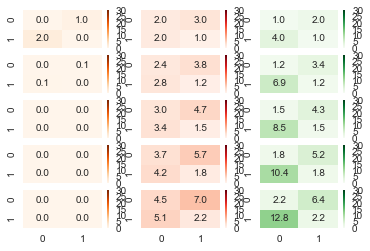

In [4]:
model.plotMap(model.diffeqSolve(params1, testobject), testobject.tot_time, 5)

To check if our code works well, let's run MCMC on our model.

In [5]:
import emcee
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as op

# Find MAP values
# Initial guess
x0 = np.array([0.1, 0.5, 0.5])
res = op.fmin(model.negative_log_posterior, x0, args=(testobject, 0.4))

print(res)

Optimization terminated successfully.
         Current function value: 0.953210
         Iterations: 81
         Function evaluations: 144
[ 0.10000027  0.1999926   0.39996942]


CPU times: user 23.2 s, sys: 101 ms, total: 23.3 s
Wall time: 23.5 s
Done


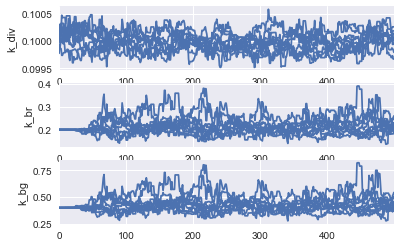

In [6]:
# We have 3 parameters. 
# We use 20 walkers and 500 steps, which turns out to be a sufficient number.
ndim = 3
nwalkers = 20
nsteps = 500
init_params = res

# Starting positions in Gaussian ball
starting_positions = [init_params + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, model.log_posterior, 
                                args=(testobject, 0.4))

# Run the sampler.
%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

# Let's plot 10 walkers from the samler chain to observe convergence.
fig, (ax_k_div, ax_k_br, ax_k_bg) = plt.subplots(3)
ax_k_div.set(ylabel='k_div')
ax_k_br.set(ylabel='k_br')
ax_k_bg.set(ylabel='k_bg')
for i in range(10):
    sns.tsplot(sampler.chain[i,:,0], ax=ax_k_div)
    sns.tsplot(sampler.chain[i,:,1], ax=ax_k_br)
    sns.tsplot(sampler.chain[i,:,2], ax=ax_k_bg)

/Users/lsh/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/lsh/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


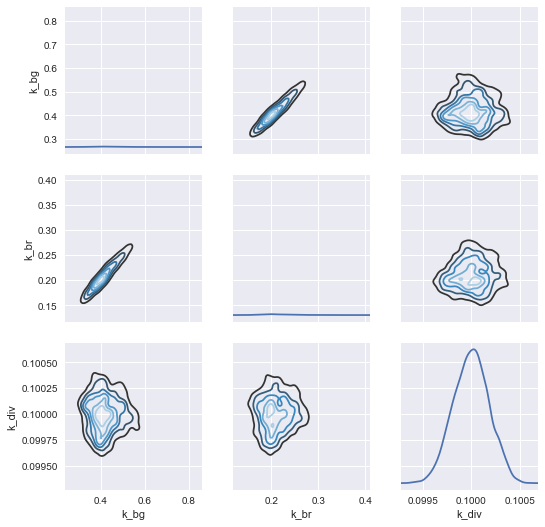

In [7]:
# Since V_b converges around 300, let's set burnin time as 300 steps.
samples = sampler.chain[:,300:,:]

# reshape the samples into an array with dimension (ndim) x (# of data) 1D array 
traces = samples.reshape(-1, ndim).T

# Create a pandas DataFrame with labels.
parameter_samples = pd.DataFrame({'k_div': traces[0], 'k_br': traces[1], 'k_bg': traces[2]})

# Draw joint_kde plot (Referred to: http://seaborn.pydata.org/tutorial/distributions.html)
g = sns.PairGrid(parameter_samples)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6);

We obtain the result which agrees with the parameters used to create the simulated data, as expected.

### 4/24
## Inference with the actual data

Now, let's use the actual data to make an inference. Firstly, let's plot the location of cells of each type. Note that the data contains total 175 steps of unit time.

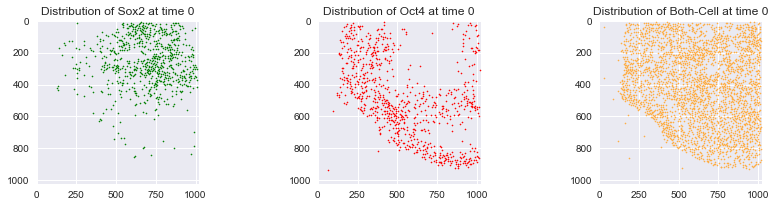

In [19]:
celldensity.draw_cell_loc('full-data.csv', 'Sox2', 'Oct4', 0)

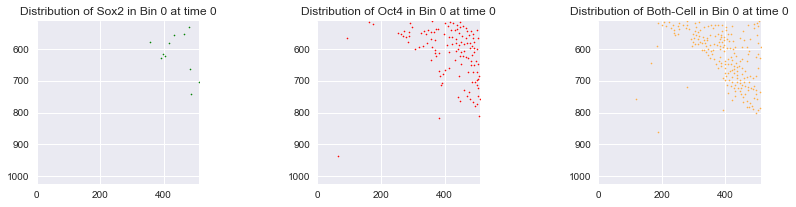

In [20]:
# Following plot shows that the bin numbering starts from the bottom left corner in this plot.
celldensity.draw_cell_loc('full-data.csv', 'Sox2', 'Oct4',  0, BinDiv=2, bin_i=0, bin_j=0)

Let's create celldensity object and observe the change of cell numbers in 2x2 bin.

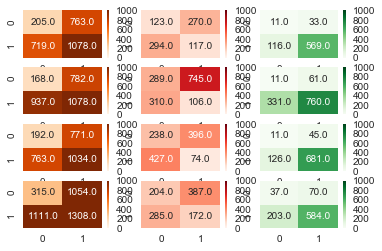

In [21]:
# Create object
testobject = io.read('full-data.csv', 'Sox2', 'Oct4', 2)
testobject.plotMap(4)

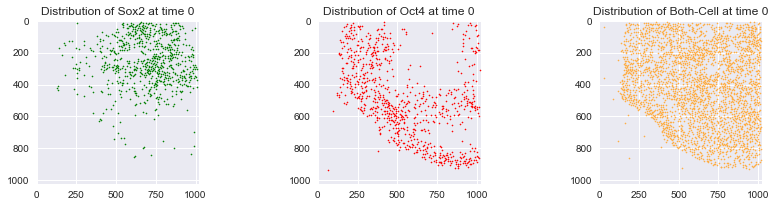

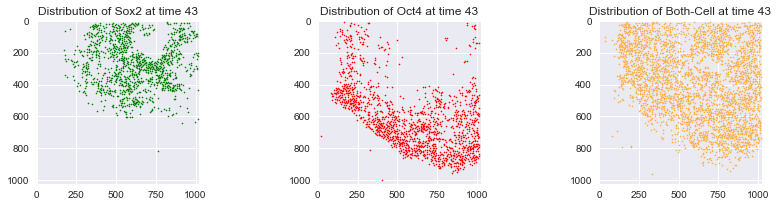

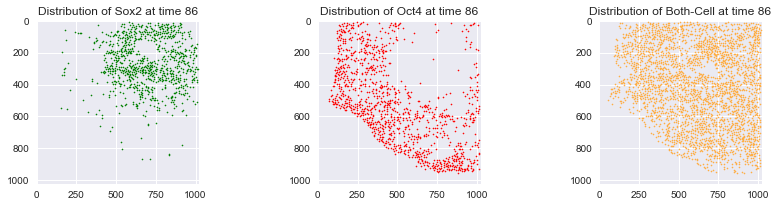

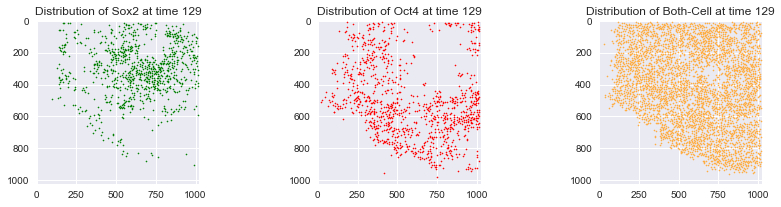

In [22]:
# Plot the images of the cell locations over time
steps = 175
plotNum = 4
for i in range(plotNum):
    celldensity.draw_cell_loc('full-data.csv', 'Sox2', 'Oct4', i*int(steps/plotNum))

Note that the y-axis is inverted; zero is located at the top instead of bottom. Since our original image is generated by matlab which inverts the y-axis, we intentionally inverted y-axis in our python script so that comparison would be easier. Thus, in this plot, the bin numering starts from bottom left corner while in our heatmap using the actual dataframe, the bin numbering starts from the top left corner.

It is difficult to observe monotonic trend of each type of cell. As the number of both-cells is increasing, we expect to retrieve certain division rate, but the transition from both-cell to Oct4 (red) or Sox2 (green) is not clear. For the estimate, we repeat the inference done above with actual data.

In [23]:
# Parameters to calculate likelihood function
params1 = [0.05, 0.1, 0.6]
params2 = [0.1, 0.2, 0.4]

# Calculate log_likelihood function
# sigma_n is set arbitrarily
val_1 = model.log_likelihood(params1, testobject, 1000)
val_2 = model.log_likelihood(params2, testobject, 1000)

print("Log-Likelihood function value for parameter set 1 is %.5f" %(val_1))
print("Log-Likelihood function value for parameter set 2 is %.5f" %(val_2))

Log-Likelihood function value for parameter set 1 is -17255.24786
Log-Likelihood function value for parameter set 2 is -19425.13243


In [24]:
# Find MAP values
# Initial guess
x0 = np.array([0.1, 0.5, 0.5])
res = op.fmin(model.negative_log_posterior, x0, args=(testobject, 1000))

print(res)

Optimization terminated successfully.
         Current function value: 16764.467604
         Iterations: 108
         Function evaluations: 207
[  1.69741608e-10   6.94622468e-01   6.90542185e-01]


CPU times: user 16.7 s, sys: 125 ms, total: 16.8 s
Wall time: 17.1 s
Done


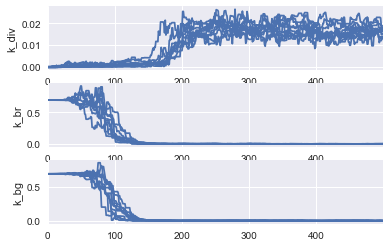

In [25]:
# We have 3 parameters. 
# We use 20 walkers and 500 steps, which turns out to be a sufficient number.
ndim = 3
nwalkers = 20
nsteps = 500
init_params = res

# Starting positions in Gaussian ball
starting_positions = [init_params + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, model.log_posterior, 
                                args=(testobject, 1000))

# Run the sampler.
%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

# Let's plot 10 walkers from the samler chain to observe convergence.
fig, (ax_k_div, ax_k_br, ax_k_bg) = plt.subplots(3)
ax_k_div.set(ylabel='k_div')
ax_k_br.set(ylabel='k_br')
ax_k_bg.set(ylabel='k_bg')
for i in range(10):
    sns.tsplot(sampler.chain[i,:,0], ax=ax_k_div)
    sns.tsplot(sampler.chain[i,:,1], ax=ax_k_br)
    sns.tsplot(sampler.chain[i,:,2], ax=ax_k_bg)

/Users/lsh/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/lsh/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


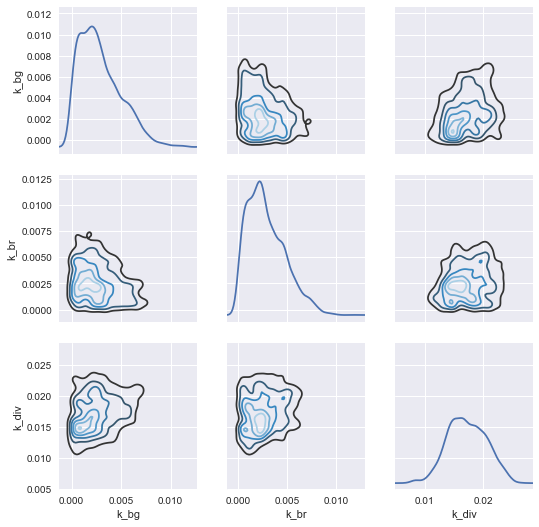

In [26]:
# Since V_b converges around 300, let's set burnin time as 300 steps.
samples = sampler.chain[:,300:,:]

# reshape the samples into an array with dimension (ndim) x (# of data) 1D array 
traces = samples.reshape(-1, ndim).T

# Create a pandas DataFrame with labels.
parameter_samples = pd.DataFrame({'k_div': traces[0], 'k_br': traces[1], 'k_bg': traces[2]})

# Draw joint_kde plot (Referred to: http://seaborn.pydata.org/tutorial/distributions.html)
g = sns.PairGrid(parameter_samples)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6);

There exists about one order of magnitude difference between $k_{div}$ and $k_{bg}$&$k_{br}$. While we expect to see transition, it seems our model is too simplified so that $k_{bg}$&$k_{br}$ is overwhelmed by $k_{div}$.

In [4]:
testobject.data

R                                         G                        \
            0          1          2         3         0          1          2   
0    2.000000   3.000000   2.000000  1.000000  1.000000   2.000000   4.000000   
1    2.138560   3.325804   2.374487  1.069280  1.069280   2.374487   4.748975   
2    2.286720   3.640606   2.707772  1.143360  1.143360   2.707772   5.415544   
3    2.445144   3.953199   3.016110  1.222572  1.222572   3.016110   6.032220   
4    2.614544   4.270267   3.311445  1.307272  1.307272   3.311445   6.622890   
5    2.795680   4.597008   3.602657  1.397840  1.397840   3.602657   7.205313   
6    2.989365   4.937593   3.896456  1.494683  1.494683   3.896456   7.792912   
7    3.196469   5.295483   4.198028  1.598234  1.598234   4.198028   8.396056   
8    3.417921   5.673667   4.511492  1.708960  1.708960   4.511492   9.022985   
9    3.654715   6.074832   4.840234  1.827357  1.827357   4.840234   9.680469   
10   3.907914   6.501486   5.187145  1.953957  1.953957   5.187145  10.374290   
11   4.178655   6.956052   5.554795  2.089327  2.089327   5.554795  11.109589   
12   4.468152   7.440931   5.945557  2.234076  2.234076   5.945557  11.891114   
13   4.777706   7.958559   6.361705  2.388853  2.388853   6.361705  12.723411   
14   5.108707   8.511445   6.805478  2.554353  2.554353   6.805478  13.610956   
15   5.462638   9.102204   7.279132  2.731319  2.731319   7.279132  14.558264   
16   5.841091   9.733582   7.784983  2.920545  2.920545   7.784983  15.569966   
17   6.245762  10.408481   8.325438  3.122881  3.122881   8.325438  16.650876   
18   6.678469  11.129979   8.903020  3.339235  3.339235   8.903020  17.806040   
19   7.141155  11.901350   9.520391  3.570577  3.570577   9.520391  19.040781   
20   7.635895  12.726080  10.180371  3.817947  3.817947  10.180371  20.360742   
21   8.164911  13.607890  10.885959  4.082455  4.082455  10.885959  21.771918   
22   8.730577  14.550750  11.640348  4.365288  4.365288  11.640348  23.280696   
23   9.335432  15.558903  12.446942  4.667716  4.667716  12.446942  24.893883   
24   9.982192  16.636879  13.309374  4.991096  4.991096  13.309374  26.618748   
25  10.673760  17.789522  14.231525  5.336880  5.336880  14.231525  28.463050   
26  11.413239  19.022009  15.217541  5.706620  5.706620  15.217541  30.435083   
27  12.203950  20.339876  16.271854  6.101975  6.101975  16.271854  32.543707   
28  13.049441  21.749039  17.399198  6.524721  6.524720  17.399198  34.798396   
29  13.953508  23.255826  18.604636  6.976754  6.976754  18.604636  37.209273   

             Both                           
           3    0         1         2    3  
0   1.000000  0.0  1.000000  2.000000  0.0  
1   1.069280  0.0  0.715389  1.430779  0.0  
2   1.143360  0.0  0.511782  1.023564  0.0  
3   1.222572  0.0  0.366123  0.732247  0.0  
4   1.307272  0.0  0.261921  0.523842  0.0  
5   1.397840  0.0  0.187375  0.374751  0.0  
6   1.494683  0.0  0.134046  0.268093  0.0  
7   1.598234  0.0  0.095895  0.191791  0.0  
8   1.708960  0.0  0.068603  0.137205  0.0  
9   1.827357  0.0  0.049078  0.098155  0.0  
10  1.953957  0.0  0.035110  0.070219  0.0  
11  2.089327  0.0  0.025117  0.050234  0.0  
12  2.234076  0.0  0.017968  0.035937  0.0  
13  2.388853  0.0  0.012854  0.025709  0.0  
14  2.554353  0.0  0.009196  0.018392  0.0  
15  2.731319  0.0  0.006579  0.013157  0.0  
16  2.920545  0.0  0.004706  0.009413  0.0  
17  3.122881  0.0  0.003367  0.006734  0.0  
18  3.339235  0.0  0.002409  0.004817  0.0  
19  3.570577  0.0  0.001723  0.003446  0.0  
20  3.817947  0.0  0.001233  0.002465  0.0  
21  4.082455  0.0  0.000882  0.001764  0.0  
22  4.365288  0.0  0.000631  0.001262  0.0  
23  4.667716  0.0  0.000451  0.000903  0.0  
24  4.991096  0.0  0.000323  0.000646  0.0  
25  5.336880  0.0  0.000231  0.000462  0.0  
26  5.706620  0.0  0.000165  0.000330  0.0  
27  6.101975  0.0  0.000118  0.000236  0.0  
28  6.524721  0.0  0.000085  0.000169  0.0  
29  6.976754  0.0  0.000